# Twitter Sentiment Analysis

> Di project ini saya akan mencoba melakukan sentiment analysis menggunakan tweet-tweet yang berhubungan dengan kata `AlbertEinstein`. 

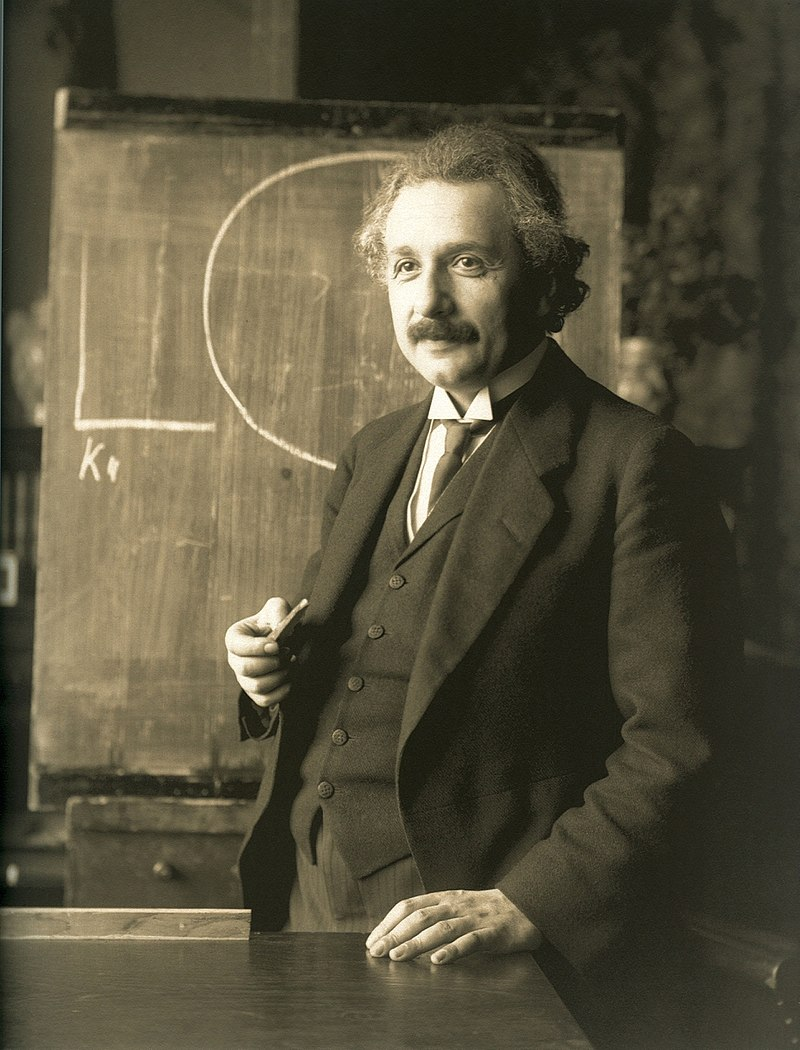

In [108]:
from IPython.display import Image

Image(filename='einstein.jpg', height = 200, width = 300) 

source : http://www.bhm.ch/de/news_04a.cfm?bid=4&jahr=2006

In [109]:
import tweepy
from twitter_key import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [110]:
auth = tweepy.OAuthHandler(API_key, API_secret_key)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [111]:
tweets = api.user_timeline(screen_name = 'AlbertEinstein', count = 200, lang = 'en', tweet_mode = 'extended')

Saya memilih kata `AlbertEinstein` karena alasan personal, mengingat saya dulu kuliah fisika dan masuk ke peminatan fisika teori. Saya juga beruntung dapat belajar Relativitas umum saat kuliah, dimana itu adalah salah satu karya Einstein yang paling saya kagumi. 

In [112]:
for tweet in tweets[:5]:
    print(tweet['full_text'] + '\n')

Can you solve Einstein's riddle?(via @TED_ED)
https://t.co/7cfvndA0HD

The “rectangular peg problem” seems like the kind of question a geometry student might settle with a ruler and compass, but it has resisted mathematicians’ best efforts for decades. Working remotely, two mathematicians have now found the answer. https://t.co/XVJV0qetSz

How are the elements that make up life distributed among stars and planets? https://t.co/moT1UCiaoL

Struggling to stay motivated during this time? Here are 13 topics young physicists can work on to take control of their situation &amp; keep moving forward regardless of the uncertainties they now face. (via @APSphysics) https://t.co/CJvf2PzzCa

Fan art Friday! https://t.co/LvEbq7BhNQ



In [113]:
df = pd.DataFrame([tweet['full_text'] for tweet in tweets], columns = ['Tweets'])

df.head()

,Tweets
0,Can you solve Einstein's riddle?(via @TED_ED)\...
1,The “rectangular peg problem” seems like the k...
2,How are the elements that make up life distrib...
3,Struggling to stay motivated during this time?...
4,Fan art Friday! https://t.co/LvEbq7BhNQ


In [114]:
def clean(txt):
    txt = re.sub('@[A-Za-z0–9]+', '', txt) #Menghilangkan mention
    txt = re.sub('https?:\/\/\S+', '', txt) # Menghilangkan Link
    txt = re.sub('RT[\s]+', '', txt) # Menghilangkan RT
    txt = re.sub('#', '', txt) #Menghilangkan HashTag
    txt = re.sub('[%s]' % re.escape(string.punctuation), '', txt)
    txt = re.sub(r'(\w)\1+', r'\1', txt)
    txt = str(txt).lower()
    return txt

df['Tweets'] = df['Tweets'].apply(clean)

In [115]:
df

,Tweets
0,can you solve einsteins ridlevia ed\n
1,the “rectangular peg problem” sems like the ki...
2,how are the elements that make up life distrib...
3,strugling to stay motivated during this time h...
4,fan art friday
...,...
195,genius
196,its al relative
197,any future colision betwen our observable univ...
198,how wil the pandemic impact astronomy research...


In [116]:
def re_stopword(x):
    return [y for y in x if y not in stopwords.words('english')] #membuang kata-kata tidak 'penting'

In [117]:
df['split'] = df['Tweets'].apply(lambda x : x.split())
df['split'] = df['split'].apply(lambda x:re_stopword(x))

In [118]:
top = Counter([i for j in df['split'] for i in j])
temp = pd.DataFrame(top.most_common(11))
temp = temp.iloc[1:,:]
temp.columns = ['Word', 'Counts']
print('Top 10 Most Common Words')
temp

Top 10 Most Common Words


,Word,Counts
1,via,38
2,new,20
3,albert,20
4,black,19
5,universe,18
6,einsteins,15
7,scientists,13
8,physicist,13
9,theory,13
10,physicists,12


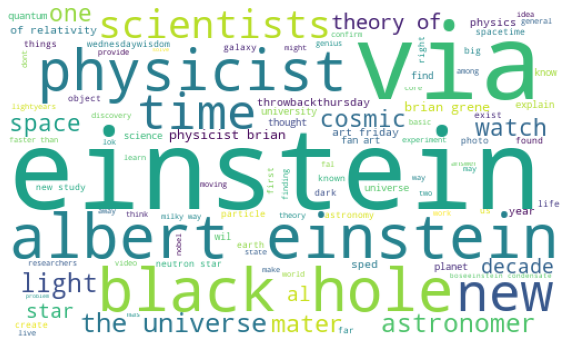

In [119]:
allWords = ''.join(i for i in df['Tweets'])
wordsCloud = WordCloud(max_font_size=100, max_words=100, width=500, height=300, background_color = 'white').generate(allWords)

plt.figure(figsize=(8,8))
plt.imshow(wordsCloud)
plt.axis("off")
plt.tight_layout()
plt.show()

> Dari gambar di atas, dapat dilihat kontribusi-kontribusi Einstein di dunia fisika, seperti misalnya relativitas umum dan lubang hitam. Terlihat juga ada kata Hawking dan Brian Greene di atas, dua fisikawan yang saya sangat kagumi. Menarik bisa melihat ada kata 'confirm' di atas, mungkin ini berhubungan dengan penemuan beberapa tahun yang lalu tentang gelombang gravitasi. 

In [120]:
def subjectivity(txt):
    return TextBlob(txt).sentiment.subjectivity

def polarity(txt):
    return TextBlob(txt).sentiment.polarity

In [121]:
df['Subjectivity'] = df['Tweets'].apply(subjectivity)
df['Polarity'] = df['Tweets'].apply(polarity)

In [122]:
df.head()

,Tweets,split,Subjectivity,Polarity
0,can you solve einsteins ridlevia ed\n,"[solve, einsteins, ridlevia, ed]",0.000000,0.0
1,the “rectangular peg problem” sems like the ki...,"[“rectangular, peg, problem”, sems, like, kind...",0.466667,0.5
2,how are the elements that make up life distrib...,"[elements, make, life, distributed, among, sta...",0.000000,0.0
3,strugling to stay motivated during this time h...,"[strugling, stay, motivated, time, 13, topics,...",0.400000,0.1
4,fan art friday,"[fan, art, friday]",0.000000,0.0


In [123]:
def sentiment(x):
    if x > 0:
        return 'positive'
    elif x < 0:
        return 'negative'
    else:
        return 'neutral'

In [124]:
df['sentiment'] = df['Polarity'].apply(sentiment)

In [125]:
df.head()

,Tweets,split,Subjectivity,Polarity,sentiment
0,can you solve einsteins ridlevia ed\n,"[solve, einsteins, ridlevia, ed]",0.000000,0.0,neutral
1,the “rectangular peg problem” sems like the ki...,"[“rectangular, peg, problem”, sems, like, kind...",0.466667,0.5,positive
2,how are the elements that make up life distrib...,"[elements, make, life, distributed, among, sta...",0.000000,0.0,neutral
3,strugling to stay motivated during this time h...,"[strugling, stay, motivated, time, 13, topics,...",0.400000,0.1,positive
4,fan art friday,"[fan, art, friday]",0.000000,0.0,neutral


positive    87
neutral     76
negative    37
Name: sentiment, dtype: int64


Text(0.5, 1.0, 'Sentiment')

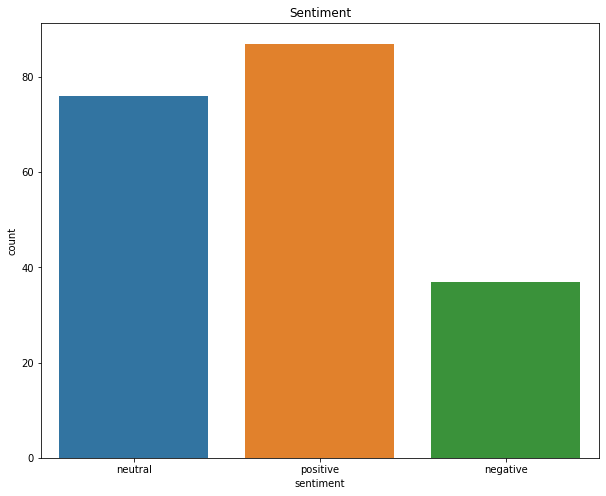

In [126]:
plt.figure(figsize = (10,8))
print(df['sentiment'].value_counts())
sns.countplot(df['sentiment'])
plt.title('Sentiment')

> Menarik melihat kebanyakan tweet-tweet di dataset ini positive untuk kata `AlbertEinstein`

# Modeling

## Dataset Splitting

In [127]:
X = df['Tweets']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(160,) (40,) (160,) (40,)


Saya akan menggunakan MultinominalNaiveBayes dalam melakukan modeling

In [128]:
paramsNB = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'nb__alpha': [1, 1e-1]
}

In [129]:
stop_words = set(stopwords.words('english'))

In [130]:
model = Pipeline([
    ('vect', CountVectorizer(stop_words = stop_words)),
    ('tfidf', TfidfTransformer()),
    ('nb', MultinomialNB())
])

In [131]:
model_tuned = GridSearchCV(model, paramsNB, cv=3, scoring = 'f1_macro')
model_tuned.fit(X_train, y_train)

print(model_tuned.best_params_)

{'nb__alpha': 0.1, 'tfidf__norm': 'l2', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


In [132]:
print(classification_report(y_test, model_tuned.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

    negative       0.75      0.86      0.80         7
     neutral       0.88      0.78      0.82        18
    positive       0.75      0.80      0.77        15

    accuracy                           0.80        40
   macro avg       0.79      0.81      0.80        40
weighted avg       0.81      0.80      0.80        40



> Seharusnya model bisa lebih baik lagi.

# Sanity Check

In [136]:
model_tuned.best_estimator_.predict(['Albert Einstein is considered the greatest scientist'])

array(['neutral'], dtype='<U8')

> Saya rasa model ini masih jauh dari sempurna. Namun ini bisa menjadi gambaran cara untuk melakukan sentiment analysis menggunakan tweet-tweet di twitter.